In [1]:
import sys
sys.path.insert(0, '../Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from pysr import PySRRegressor
import sympy 
import pandas as pd

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:

# Carga los archivos .xlsx
file1 = '../DataExperiments/WT_in_LB_data_s1.XLSX'
file2 = '../DataExperiments/different_conditions_data_s2.XLSX'

# Lee las hojas de los archivos
df1 = pd.read_excel(file1, engine='openpyxl')  # Especifica la hoja si es necesario: sheet_name='nombre_hoja'
df2 = pd.read_excel(file2, engine='openpyxl')

# Cambiar la fila 0 a la nueva cabecera
df2.columns = df2.iloc[0]  # Establecer la primera fila como nueva cabecera
df2 = df2[1:]  # Eliminar la primera fila

# Reiniciar los índices (opcional, si quieres que empiece desde 0)
df2 = df2.reset_index(drop=True)

# Muestra los DataFrames
print("Archivo 1:")
display(df1)

print("Archivo 2:")
display(df2)


Archivo 1:


,Cycle Nr.,Time [s],Temp. [°C],G4,G5,G6,G7,G8,G9,G10,G11,G12,H1,H2,H3,H4,H5,H6
0,1,0.0,30.8,0.0922,0.0928,0.0928,0.0931,0.0928,0.0927,0.0916,0.0921,0.0911,0.0936,0.0925,0.0918,0.0929,0.0931,0.0931
1,2,678.6,30.7,0.0951,0.0957,0.0959,0.0959,0.0957,0.0953,0.0947,0.0951,0.0941,0.0970,0.0958,0.0951,0.0963,0.0963,0.0962
2,3,1357.1,30.4,0.0951,0.0958,0.0957,0.0960,0.0958,0.0954,0.0947,0.0951,0.0943,0.0971,0.0959,0.0952,0.0965,0.0964,0.0963
3,4,2035.7,30.2,0.0955,0.0962,0.0961,0.0965,0.0964,0.0958,0.0950,0.0957,0.0947,0.0975,0.0964,0.0957,0.0969,0.0969,0.0969
4,5,2714.2,30.0,0.0960,0.0969,0.0965,0.0968,0.0968,0.0964,0.0956,0.0963,0.0953,0.0981,0.0969,0.0961,0.0974,0.0973,0.0973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,495,335199.8,30.8,0.8186,0.8214,0.8188,0.8198,0.8221,0.8201,0.8296,0.8418,0.8292,0.4360,0.7711,0.8043,0.8181,0.8181,0.8153
495,496,335878.3,30.9,0.8184,0.8222,0.8185,0.8178,0.8201,0.8182,0.8277,0.8379,0.8274,0.4379,0.7729,0.8038,0.8198,0.8180,0.8154
496,497,336556.8,30.8,0.8183,0.8222,0.8169,0.8204,0.8214,0.8186,0.8287,0.8409,0.8289,0.4304,0.7719,0.8040,0.8187,0.8172,0.8154
497,498,337235.3,30.8,0.8172,0.8211,0.8194,0.8206,0.8227,0.8201,0.8303,0.8417,0.8280,0.4321,0.7717,0.8043,0.8194,0.8173,0.8143


Archivo 2:


,Cycle Nr.,Time [s],Temp. [°C],A1,A2,A3,A4,A5,A6,A7,...,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11
0,1,0,30,0.0929,0.0971,0.0948,0.0961,0.0939,0.0934,0.0938,...,0.0913,0.0914,0.0924,0.0916,0.0925,0.0921,0.092,0.093,0.0927,0.093
1,2,678.6,30.5,0.0925,0.0962,0.0946,0.0953,0.0935,0.0931,0.0933,...,0.0913,0.0916,0.0926,0.092,0.0914,0.0921,0.0921,0.0931,0.0932,0.0925
2,3,1357.2,30.1,0.0926,0.0962,0.095,0.0954,0.0936,0.0932,0.0932,...,0.0916,0.0917,0.0927,0.0918,0.0917,0.0922,0.0923,0.0932,0.0932,0.0927
3,4,2035.8,30,0.0928,0.0981,0.0949,0.0956,0.0937,0.0934,0.0934,...,0.092,0.0921,0.0931,0.0922,0.0922,0.0928,0.0926,0.0936,0.0937,0.093
4,5,2714.4,30.3,0.0933,0.0985,0.0953,0.096,0.0942,0.0939,0.0938,...,0.0925,0.0927,0.0937,0.0928,0.093,0.0933,0.0933,0.0943,0.0944,0.0938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,338,228685.2,29.9,0.5954,0.6453,0.6513,0.6593,0.6599,0.6576,0.5901,...,0.0926,0.0926,0.0935,0.0924,0.0949,1.0018,0.9769,0.9848,0.9871,0.9972
338,339,229363.7,29.8,0.5937,0.6448,0.6495,0.6568,0.6572,0.6564,0.5898,...,0.0926,0.0927,0.0934,0.0926,0.0953,1.0017,0.98,0.9857,0.9868,0.9976
339,340,230042.3,29.9,0.5923,0.6429,0.6487,0.6575,0.6589,0.6572,0.5889,...,0.0925,0.0925,0.0933,0.0923,0.0947,1.0009,0.9758,0.9833,0.9846,0.9963
340,341,230720.9,30.3,0.5912,0.6419,0.6484,0.6568,0.657,0.6548,0.5888,...,0.0923,0.0924,0.0932,0.0921,0.0942,1.0004,0.9763,0.9843,0.9845,0.9981


In [3]:
c=-1
P_exp=np.array(df1.iloc[:, 3:].drop('H1',axis=1))[:c]
T_exp=np.array(df1['Time [s]'])[:c]

T_max=max(T_exp)
T_exp=T_exp/max(T_exp)
N_exp=P_exp.shape[1]
N_exp,T_max

(14, 337235.3)

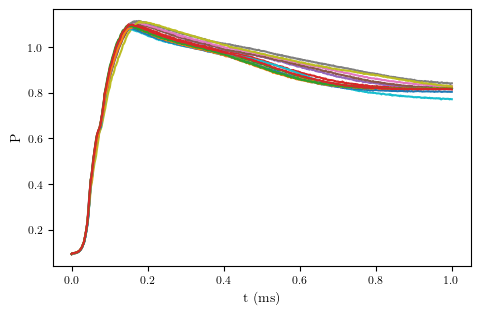

In [4]:
for i in range(N_exp):
    plt.plot(T_exp,P_exp[:, i])
plt.xlabel('t (ms)')
plt.ylabel('P ')
plt.show()

In [5]:
N_f = 100 # Number of residual point
N_d = 600 #Number of data

P_star = P_exp.T.flatten().reshape([-1,1])
T_star = np.tile(T_exp,N_exp).reshape([-1,1])

# Doman bounds
lb = T_star.min(0)
ub = T_star.max(0) 

# Initial Condition
xx1 = T_star[::len(T_exp)]
uu1 = P_star[::len(T_exp)]

# Additional data
idx = np.random.choice(P_star.shape[0], N_d-len(uu1), replace=False)
xxd = T_star[idx]
uud = P_star[idx]

T_u_train = np.concatenate((xx1,xxd)).reshape([-1,1])
p_train = np.concatenate((uu1,uud)).reshape([-1,1])

T_f_train = lb + (ub-lb)*lhs(1, N_f)

T_u_train_tf = tf.convert_to_tensor(T_u_train, dtype=tf.float32)
p_train_tf =   tf.convert_to_tensor(p_train, dtype=tf.float32)
T_f_train_tf = tf.convert_to_tensor(T_f_train, dtype=tf.float32)
P_star_tf = tf.convert_to_tensor(P_star, dtype=tf.float32)

2024-11-06 17:46:00.379595: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2024-11-06 17:46:00.379897: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublas64_11.dll'; dlerror: cublas64_11.dll not found
2024-11-06 17:46:00.380168: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublasLt64_11.dll'; dlerror: cublasLt64_11.dll not found
2024-11-06 17:46:00.380430: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cufft64_10.dll'; dlerror: cufft64_10.dll not found
2024-11-06 17:46:00.380687: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'curand64_10.dll'; dlerror: curand64_10.dll not found
2024-11-06 17:46:00.380933: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dyna

In [6]:
N_f = 300 # Number of residual point
N_d = 600 #Number of data

P_star = P_exp.T.flatten().reshape([-1,1])
T_star = np.tile(T_exp,N_exp).reshape([-1,1])

# Doman bounds
lb = T_star.min(0)
ub = T_star.max(0) 

# Initial Condition
xx1 = T_star[::len(T_exp)]
uu1 = P_star[::len(T_exp)]

# Additional data
idx = np.random.choice(P_star.shape[0], N_d-len(uu1), replace=False)
xxd = T_star[idx]
uud = P_star[idx]

T_u_train = np.concatenate((xx1,xxd)).reshape([-1,1])
p_train = np.concatenate((uu1,uud)).reshape([-1,1])

T_f_train = lb + (ub-lb)*lhs(1, N_f)

T_u_train_tf = tf.convert_to_tensor(T_u_train, dtype=tf.float32)
p_train_tf =   tf.convert_to_tensor(p_train, dtype=tf.float32)
T_f_train_tf = tf.convert_to_tensor(T_f_train, dtype=tf.float32)
P_star_tf = tf.convert_to_tensor(P_star, dtype=tf.float32)

In [7]:
T_star.shape

(6972, 1)

In [8]:
P_star.shape

(6972, 1)

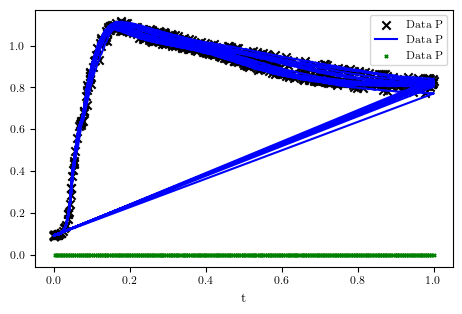

In [9]:
plt.scatter(T_u_train, p_train, marker='x', color='black',label='Data P')
plt.plot(T_star, P_star, color='blue',label='Data P')
plt.scatter(T_f_train_tf, np.zeros_like(T_f_train_tf), s=5, marker='x', color='green',label='Data P')


plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

In [10]:
np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
#os.environ[‘TF_ENABLE_AUTO_MIXED_PRECISION’] = ‘1’



# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = 2.0*(X - lb)/(ub - lb) - 1.0
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b 

def train_vars_total(W, b, lambda_r, lambda_b):
    return W + b + lambda_r + lambda_b

def net(t, w, b):
    p = DNN(t, w, b)
    return p

def loss_weight(N_r, N_b):
    alpha_b = tf.Variable(tf.reshape(tf.repeat(1000.0, N_b), (N_b, -1))) 
    alpha_r = tf.Variable(tf.ones(shape=[N_r, 1]), dtype=tf.float32)
    alpha_s = tf.Variable(tf.ones(shape=[N_r, 1]), dtype=tf.float32)
    alpha_a = tf.Variable(tf.ones(shape=[N_r, 1]), dtype=tf.float32)
    alpha_0 = tf.Variable(tf.reshape(tf.repeat(1000.0, 1), (1, -1))) 


    return alpha_r, alpha_b, alpha_s, alpha_a, alpha_0

#@tf.function(jit_compile=True)
@tf.function()
def net_f(t, W_p, b_p, W_phi_s, b_phi_s):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([t])
        u=net(t, W_p, b_p)

        lnp=u[:,0:1]
        lns=u[:,1:2]

        p=tf.exp(lnp)
        s=tf.exp(lns)
        phi=net(tf.concat([p, s],1), W_phi_s, b_phi_s)
        # phi=tf.exp(lnphi)


    p_t = tape1.gradient(p, t) 
    s_t = tape1.gradient(s, t) 

    f_p = p_t - phi*p*s
    f_s = s_t + phi*p*s
    
    return f_p, f_s


#@tf.function()
# @tf.function()
def train_step(W_p, b_p, W_phi_s, b_phi_s, X_u_train_tf, p_train_tf, X_f_train_tf, lambda_r, lambda_b, lambda_s, lambda_0, opt):
    
    t_u = X_u_train_tf
    t_f = X_f_train_tf

    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W_p, b_p, W_phi_s, b_phi_s, lambda_r, lambda_b])
        u_nn = net(t_u, W_p, b_p) 
        lnp=u_nn[:,0:1]
        p_nn=tf.exp(lnp)
        f_p, f_s= net_f(t_f, W_p, b_p, W_phi_s, b_phi_s)

        u_00 = net(tf.ones([1,1]), W_p, b_p) 
        lns=u_00[:,1:2]
        s_00=tf.exp(lns)

        loss_p = tf.square(lambda_b*(p_nn - p_train_tf))
        loss_0 = tf.square(lambda_0*(s_00 - 0))
        loss_fp = tf.square(lambda_r*f_p) 
        loss_fs = tf.square(lambda_s*f_s) 


        loss =  tf.reduce_mean(loss_p) + tf.reduce_mean(loss_fp)+ tf.reduce_mean(loss_fs)+ tf.reduce_mean(loss_0)  

    grads_p = tape.gradient(loss, train_vars(W_p, b_p))
    grads_phi_s = tape.gradient(loss, train_vars(W_phi_s, b_phi_s))

    grads_u = tape.gradient(loss, lambda_r)
    grads_b = tape.gradient(loss, lambda_b)
    grads_s = tape.gradient(loss, lambda_s)
    grads_0 = tape.gradient(loss, lambda_0)


    opt.apply_gradients(zip([-grads_u], [lambda_r]))
    opt.apply_gradients(zip([-grads_b], [lambda_b]))
    opt.apply_gradients(zip([-grads_s], [lambda_s]))
    opt.apply_gradients(zip([-grads_0], [lambda_0]))


    opt.apply_gradients(zip(grads_p, train_vars(W_p, b_p)))
    opt.apply_gradients(zip(grads_phi_s, train_vars(W_phi_s, b_phi_s)))

   
    return loss, tf.reduce_mean(tf.square((p_nn - p_train_tf))), tf.reduce_mean(tf.square(f_p)), tf.reduce_mean(tf.square(f_s))



layers = [1, 20, 20, 2]

L = len(layers)
W_p = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_p = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

layers = [2, 20, 20, 1]

W_phi_s= [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_phi_s = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]


lambda_r, lambda_b, lambda_s, lambda_a, lambda_0 = loss_weight(N_f, N_d)



In [11]:
@tf.function()
def predict(X_star_tf, w, b):
    u_pred = net(X_star_tf, w, b)
    return u_pred

# @tf.function()
def eval(W_p, b_p, W_phi_s, b_phi_s):

    # Evaluating total function
    T_star_tf = tf.convert_to_tensor(T_star, dtype=tf.float32)    
    u_pred = predict(T_star_tf, W_p, b_p)

    # Evaluating unknown function
    lnp = u_pred[:, 0:1]
    lns = u_pred[:, 1:2]

    p = tf.exp(lnp)
    s = tf.exp(lns)

    Nt = 1000
    T_int = tf.TensorArray(dtype=tf.float32, size=Nt)
    P_int = tf.TensorArray(dtype=tf.float32, size=Nt)
    S_int = tf.TensorArray(dtype=tf.float32, size=Nt)

    dt = 0.001

    T_int = T_int.write(0, 0.0)
    P_int = P_int.write(0, p[0])
    S_int = S_int.write(0, s[0])

    for i in range(1, Nt):
        P_last=P_int.read(i-1)
        S_last=S_int.read(i-1)
        PS = tf.concat([tf.expand_dims(P_last, axis=0), tf.expand_dims(S_last, axis=0)], axis=1)
        PHI = tf.exp(predict(PS, W_phi_s, b_phi_s))

        P_new = P_last + PHI * P_last * S_last * dt
        S_new = S_last - PHI * P_last * S_last * dt
        T_new = T_int.read(i-1) + dt

        P_new = tf.squeeze(P_new, axis=1)  
        S_new = tf.squeeze(S_new, axis=1)  

        T_int = T_int.write(i, T_new)
        P_int = P_int.write(i, P_new)
        S_int = S_int.write(i, S_new)
        

    T_int_tf = T_int.stack()
    P_int_tf = P_int.stack()
    S_int_tf = S_int.stack()
    T_int_tf=tf.reshape(T_int_tf, [-1, 1])
    u_pred = predict(T_int_tf, W_p, b_p)

    lnp = u_pred[:, 0:1]
    lns = u_pred[:, 1:2]

    p = tf.exp(lnp)
    s = tf.exp(lns)

    loss = tf.reduce_mean(tf.square(p - P_int_tf)) + tf.reduce_mean(tf.square(s - S_int_tf))

    return loss


In [12]:
lr = 1e-3
# Nmax = 15000
# Nmax = 150000
Nmax=2*10**5
# Nmax=20000



optimizer = tf.optimizers.Adam(learning_rate=lr)
optimizer2 = tf.optimizers.Adam(learning_rate=lr/10)
# optimizer3 = tf.optimizers.Adam(learning_rate=lr/100)
# optimizer3 = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
optimizer3 = tf.optimizers.Adam(learning_rate=lr/50)

# optimizer3 = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9, clipnorm=10.0)


start_time = time.time()
n=0
loss = []
loss_d = []
loss_fisp = []
loss_fiss = []
loss_reg=[]
# loss_fisa = []

# Make a new Function and ConcreteFunction for each optimizer.
train_step_1 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi_s, b_phi_s, T_u_train_tf, p_train_tf, T_f_train_tf, lambda_r, lambda_b, lambda_s,lambda_0, optimizer)
train_step_2 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi_s, b_phi_s, T_u_train_tf, p_train_tf, T_f_train_tf, lambda_r, lambda_b, lambda_s,lambda_0, optimizer)
train_step_3 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi_s, b_phi_s, T_u_train_tf, p_train_tf, T_f_train_tf, lambda_r, lambda_b, lambda_s,lambda_0, optimizer2)


while n <= Nmax:
    if n<2*10**4:
        loss_, loss_p, loss_fp, loss_fs = train_step_1(W_p, b_p, W_phi_s, b_phi_s, T_u_train_tf, p_train_tf, T_f_train_tf, lambda_r, lambda_b, lambda_s,lambda_0)
    elif n< 10**5:
        loss_, loss_p, loss_fp, loss_fs = train_step_2(W_p, b_p, W_phi_s, b_phi_s, T_u_train_tf, p_train_tf, T_f_train_tf, lambda_r, lambda_b, lambda_s,lambda_0)
    else:
        loss_, loss_p, loss_fp, loss_fs = train_step_3(W_p, b_p, W_phi_s, b_phi_s, T_u_train_tf, p_train_tf, T_f_train_tf, lambda_r, lambda_b, lambda_s,lambda_0)

    loss.append(loss_)
    loss_d.append(loss_p)
    loss_fisp.append(loss_fp)
    loss_fiss.append(loss_fs)
    # loss_fisa.append(loss_fa)



    if n % 10 == 0:

        print(f"Iteration is: {n}")
        print(f"Total loss is: {loss_}")
        print(f"Data loss is: {loss_p}")
        print(f"Physicial loss of p is: {loss_fp}")
        print(f"Physicial loss of s is: {loss_fs}")
        # if n%10000 ==0:
        #     loss_reg_=eval(W_p, b_p, W_phi_s, b_phi_s)
        #     loss_reg.append(loss_reg_)
        # print(f"Physicial loss of a is: {loss_fa}")

    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

Iteration is: 0
Total loss is: 917954.875
Data loss is: 0.07121691852807999
Physicial loss of p is: 0.4410018026828766
Physicial loss of s is: 0.6897606253623962
Iteration is: 10
Total loss is: 410983.9375
Data loss is: 0.06738469749689102
Physicial loss of p is: 0.10098671913146973
Physicial loss of s is: 0.96523517370224
Iteration is: 20
Total loss is: 150732.53125
Data loss is: 0.05877428874373436
Physicial loss of p is: 0.21023470163345337
Physicial loss of s is: 1.714850664138794
Iteration is: 30
Total loss is: 86195.484375
Data loss is: 0.052754152566194534
Physicial loss of p is: 2.526566982269287
Physicial loss of s is: 2.026050567626953
Iteration is: 40
Total loss is: 69824.53125
Data loss is: 0.052370257675647736
Physicial loss of p is: 3.087350845336914
Physicial loss of s is: 4.275121212005615
Iteration is: 50
Total loss is: 64036.49609375
Data loss is: 0.0524323470890522
Physicial loss of p is: 4.935606479644775
Physicial loss of s is: 4.739660739898682
Iteration is: 60
To

KeyboardInterrupt: 

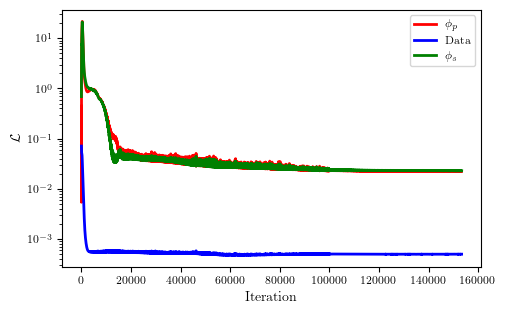

In [13]:
Nmax=len(loss)
it = np.arange(0,Nmax, 1)
loss_list = [loss[i].numpy() for i in range(0,Nmax)]
loss_data_list = [loss_d[i].numpy() for i in range(0,Nmax)]
loss_phip_list = [loss_fisp[i].numpy() for i in range(0,Nmax)]
loss_phis_list = [loss_fiss[i].numpy() for i in range(0,Nmax)]
# Nreg=len(loss_reg)
# it_r = np.arange(0,Nmax- Nmax%10000 +1, 10000)

# loss_reg_list = [loss_reg[i].numpy() for i in range(0,Nreg)]

# loss_phia_list = [loss_fisa[i].numpy() for i in range(0,Nmax)]


plt.semilogy(it, np.asarray(loss_phip_list), 'r-', linewidth = 2, label = '$\phi_p$') 

plt.semilogy(it, np.asarray(loss_data_list), 'b-', linewidth = 2, label = 'Data')  

plt.semilogy(it, np.asarray(loss_phis_list), 'g-', linewidth = 2, label = '$\phi_s$')  
# plt.semilogy(it_r, np.asarray(loss_reg_list), 'black', linewidth = 2, label = '$\phi_r$')    


# plt.semilogy(it, np.asarray(loss_phia_list), 'y-', linewidth = 2, label = '$\phi_a$')       



plt.xlabel('Iteration')
plt.ylabel('$\mathcal{L}$')  
plt.legend()  
# plt.savefig('figures/loss_phi.pdf')
plt.show()

In [ ]:
# plt.semilogy(it_r, np.asarray(loss_reg_list), 'black', linewidth = 2, label = '$\phi_r$')    


In [14]:


## Evaluating total function
T_star_tf = tf.convert_to_tensor(T_star[:len(T_exp)], dtype=tf.float32)    
u_pred = predict(T_star_tf, W_p, b_p)

# ## Evaluating unknown function
lnp=u_pred[:,0:1]
lns=u_pred[:,1:2]

p=tf.exp(lnp)
s=tf.exp(lns)



phi = predict(tf.concat([p,s],1), W_phi_s, b_phi_s)

# phi=tf.exp(lnphi)



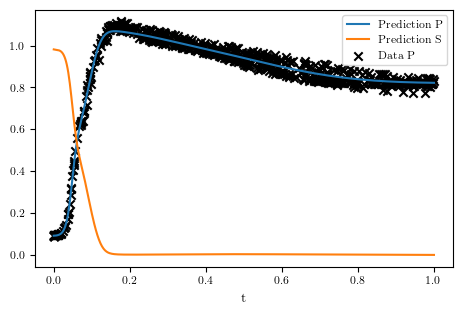

In [15]:
plt.plot(T_star_tf, p, label='Prediction P')
plt.plot(T_star_tf, s, label='Prediction S')




# for i in range(N_exp):
#     plt.plot(T_star[i*len(T_exp):(i+1)*len(T_exp)],P_star[i*len(T_exp):(i+1)*len(T_exp)],linestyle=':')

plt.scatter(T_u_train, p_train, marker='x', color='black',label='Data P')

plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

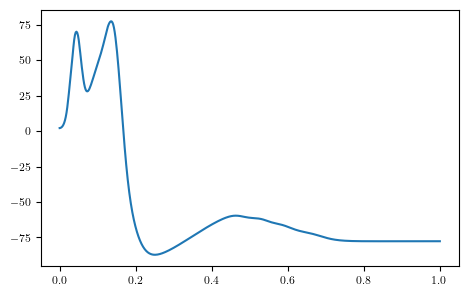

In [16]:
plt.plot(T_star_tf, phi, label='Prediction P')

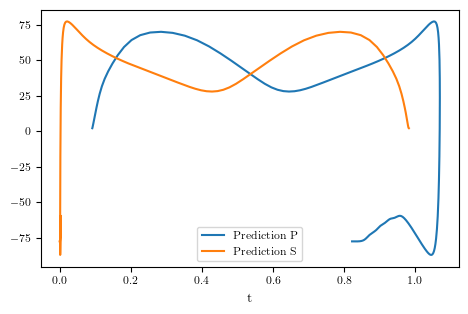

In [17]:
plt.plot( p, phi,label='Prediction P')
plt.plot( s, phi, label='Prediction S')

plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

In [21]:
Nt=1000
T_int=np.zeros(Nt)
P_int=np.zeros(Nt)
S_int=np.zeros(Nt)


dt=0.001

T_int[0]=0
# P_int[0]=np.mean(uu1) #Initial conditions
P_int[0]=np.array(p[0]) #Initial conditions
S_int[0]=np.array(s[0]) #Initial conditions




for i in range(1,Nt):

    # PSA=tf.concat([tf.convert_to_tensor(P_int[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(A_int[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    PS=tf.concat([tf.convert_to_tensor(P_int[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    # PHI=tf.exp(predict(PS , W_phi_s, b_phi_s))
    PHI=predict(PS , W_phi_s, b_phi_s)

    P_int[i]=P_int[i-1]+PHI*P_int[i-1]*S_int[i-1]*dt
    S_int[i]=S_int[i-1]-PHI*P_int[i-1]*S_int[i-1]*dt
    T_int[i]=T_int[i-1]+dt

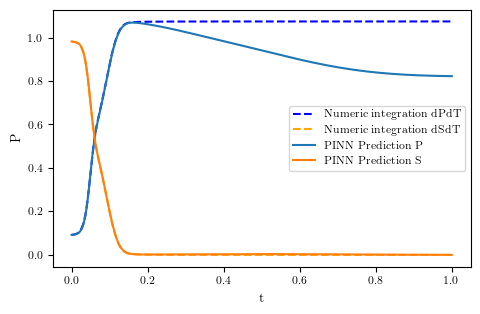

In [22]:
plt.plot(T_int, P_int, color='blue', linestyle='--', label='Numeric integration dPdT')
plt.plot(T_int, S_int, color='orange', linestyle='--', label='Numeric integration dSdT')

# plt.plot(T_int, A_int, color='green', linestyle='--', label='Numeric integration dAdT')



plt.plot(T_star_tf, p, label='PINN Prediction P')
plt.plot(T_star_tf, s, label='PINN Prediction S')

# plt.plot(T_star_tf, a, label='PINN Prediction A')

plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()